In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [20]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib
import graphviz
import matplotlib.pyplot as plt
pd.options.display.max_columns = 999
pd.options.display.max_rows = 99
%matplotlib inline

In [22]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

In [3]:
import ReadFromDB as RDB

In [30]:
def station_function(i):
    """
    Creates a sparse matrix from station information on database
    """
    
    station = RDB.add_times(RDB.create_station_dictionary(i)[i])
    weather = RDB.weather_times(RDB.read_weather(i))
#     df = pd.merge(station, weather, left_on=['date', 'hour', 'first_half_hour', 'second_half_hour'], right_on=['date', 'hour', 'first_half_hour', 'second_half_hour'], how='inner')
#     df.drop_duplicates(subset='last_updated', inplace=True)
#     df.drop_duplicates(subset='time', inplace=True)
    df = pd.merge_asof(station, weather, left_on=['last_updated'], right_on=['time'], tolerance=600, direction='nearest')
    df = df.dropna()
    df = df.reset_index()
    df.drop('index', axis=1, inplace=True)
    
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    weather_icons = ['partly-cloudy-day',
                     'partly-cloudy-night',
                     'clear-night',
                     'clear-day',
                     'fog',
                     'wind',
                     'cloudy',
                     'rain'
                    ]
    weather_cols = ['apparentTemperature',
                    'cloudCover',
                    'dewPoint',
                    'humidity',
                    'precipIntensity',
                    'precipProbability',
                    'pressure',
                    'temperature',
                    'windBearing',
                    'windGust',
                    'windSpeed',
                    'uvIndex',
                    'visibility'
                    ]
    
    for day in days:
        df[day] = 0
    
    for icon in weather_icons:
        df[icon] = 0
    
    for j in df.index:
        val = df.loc[j, 'day_x']
        for day in days:
            if val == day:
                df.loc[j, day] = 1
        
        icon_val = df.loc[j, 'icon']
        for icon in weather_icons:
            if icon_val == icon:
                df.loc[j, icon] = 1
     
    data = pd.DataFrame((df.Mon, df.Tue, df.Wed, df.Thu, df.Fri, df.Sat, df.Sun, df.hour_x)).T #df.first_half_hour, df.second_half_hour)).T
    
    for icon in weather_icons:
        data[icon] = df[icon]
    for col in weather_cols:
        data[col] = df[col]
   
    label = pd.DataFrame((df.available_bikes))
    
    return [df, data, label]

In [31]:
%%time
[station, data, label] = station_function(3)

Wall time: 17.8 s


In [202]:
param = {'tree_method':'gpu_hist', 
         'max_depth':7, 
         'eta':0.1}
num_round = 1000
def create_model(station_num):
    [station, data, label] = station_function(station_num)
    X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    model = xgb.train(param, dtrain, num_round, evals=[(dtest, 'Test')], verbose_eval=50, early_stopping_rounds=10)
    model.save_model('xgbmodels/gpu_hist/station_{}.model'.format(station_num))
    model.dump_model('xgbmodels/dump/dump_{}.raw.txt'.format(station_num))

In [204]:
%%time
for i in range(2,116):
    if not i==20:
        create_model(i)

[0]	Test-rmse:7.03707
Will train until Test-rmse hasn't improved in 10 rounds.
[50]	Test-rmse:1.38565
[100]	Test-rmse:1.23266
[150]	Test-rmse:1.18985
[200]	Test-rmse:1.16714
[250]	Test-rmse:1.15814
[300]	Test-rmse:1.15401
Stopping. Best iteration:
[321]	Test-rmse:1.15203

[0]	Test-rmse:5.54175
Will train until Test-rmse hasn't improved in 10 rounds.
[50]	Test-rmse:1.48966
[100]	Test-rmse:1.27184
[150]	Test-rmse:1.20333
[200]	Test-rmse:1.16683
[250]	Test-rmse:1.14553
[300]	Test-rmse:1.13086
[350]	Test-rmse:1.12423
Stopping. Best iteration:
[365]	Test-rmse:1.12228

[0]	Test-rmse:4.58981
Will train until Test-rmse hasn't improved in 10 rounds.
[50]	Test-rmse:1.20482
[100]	Test-rmse:0.992302
[150]	Test-rmse:0.918766
[200]	Test-rmse:0.890574
[250]	Test-rmse:0.872813
[300]	Test-rmse:0.865575
[350]	Test-rmse:0.857057
[400]	Test-rmse:0.851887
Stopping. Best iteration:
[416]	Test-rmse:0.850813

[0]	Test-rmse:16.0219
Will train until Test-rmse hasn't improved in 10 rounds.
[50]	Test-rmse:3.61355

[50]	Test-rmse:1.62163
[100]	Test-rmse:1.36794
[150]	Test-rmse:1.29577
[200]	Test-rmse:1.25633
[250]	Test-rmse:1.24277
[300]	Test-rmse:1.23054
Stopping. Best iteration:
[310]	Test-rmse:1.22882

[0]	Test-rmse:11.1552
Will train until Test-rmse hasn't improved in 10 rounds.
[50]	Test-rmse:2.97534
[100]	Test-rmse:2.51568
[150]	Test-rmse:2.3246
[200]	Test-rmse:2.22662
[250]	Test-rmse:2.18374
[300]	Test-rmse:2.16033
[350]	Test-rmse:2.14855
Stopping. Best iteration:
[384]	Test-rmse:2.14099

[0]	Test-rmse:12.4
Will train until Test-rmse hasn't improved in 10 rounds.
[50]	Test-rmse:1.81697
[100]	Test-rmse:1.51149
[150]	Test-rmse:1.38995
[200]	Test-rmse:1.34081
[250]	Test-rmse:1.30662
[300]	Test-rmse:1.2884
[350]	Test-rmse:1.27347
Stopping. Best iteration:
[378]	Test-rmse:1.26781

[0]	Test-rmse:3.44427
Will train until Test-rmse hasn't improved in 10 rounds.
[50]	Test-rmse:1.32677
[100]	Test-rmse:1.13859
[150]	Test-rmse:1.08722
[200]	Test-rmse:1.0699
[250]	Test-rmse:1.05729
Stopping. Best itera

[0]	Test-rmse:15.289
Will train until Test-rmse hasn't improved in 10 rounds.
[50]	Test-rmse:2.11141
[100]	Test-rmse:1.82059
[150]	Test-rmse:1.70032
[200]	Test-rmse:1.64126
[250]	Test-rmse:1.60671
[300]	Test-rmse:1.5876
[350]	Test-rmse:1.57601
Stopping. Best iteration:
[359]	Test-rmse:1.57396

[0]	Test-rmse:13.0035
Will train until Test-rmse hasn't improved in 10 rounds.
[50]	Test-rmse:2.22622
[100]	Test-rmse:1.91345
[150]	Test-rmse:1.82724
[200]	Test-rmse:1.79878
[250]	Test-rmse:1.77247
[300]	Test-rmse:1.76563
[350]	Test-rmse:1.75794
[400]	Test-rmse:1.7512
[450]	Test-rmse:1.74963
Stopping. Best iteration:
[440]	Test-rmse:1.74913

[0]	Test-rmse:10.5956
Will train until Test-rmse hasn't improved in 10 rounds.
[50]	Test-rmse:1.53679
[100]	Test-rmse:1.36239
[150]	Test-rmse:1.30509
[200]	Test-rmse:1.27294
Stopping. Best iteration:
[237]	Test-rmse:1.26953

[0]	Test-rmse:11.3159
Will train until Test-rmse hasn't improved in 10 rounds.
[50]	Test-rmse:1.83033
[100]	Test-rmse:1.52803
[150]	Test

Will train until Test-rmse hasn't improved in 10 rounds.
[50]	Test-rmse:2.38189
[100]	Test-rmse:1.96861
[150]	Test-rmse:1.83669
[200]	Test-rmse:1.78918
[250]	Test-rmse:1.75816
[300]	Test-rmse:1.74246
[350]	Test-rmse:1.7354
[400]	Test-rmse:1.72737
[450]	Test-rmse:1.72276
[500]	Test-rmse:1.71958
[550]	Test-rmse:1.7172
Stopping. Best iteration:
[547]	Test-rmse:1.717

[0]	Test-rmse:11.4129
Will train until Test-rmse hasn't improved in 10 rounds.
[50]	Test-rmse:1.77961
[100]	Test-rmse:1.49213
[150]	Test-rmse:1.40466
[200]	Test-rmse:1.35024
[250]	Test-rmse:1.32878
[300]	Test-rmse:1.31118
[350]	Test-rmse:1.30085
[400]	Test-rmse:1.29525
[450]	Test-rmse:1.29177
Stopping. Best iteration:
[485]	Test-rmse:1.29065

[0]	Test-rmse:15.0514
Will train until Test-rmse hasn't improved in 10 rounds.
[50]	Test-rmse:2.3474
[100]	Test-rmse:1.95019
[150]	Test-rmse:1.81241
[200]	Test-rmse:1.73222
[250]	Test-rmse:1.68545
[300]	Test-rmse:1.64629
[350]	Test-rmse:1.62358
[400]	Test-rmse:1.60956
[450]	Test-rmse:1.5

[100]	Test-rmse:1.27002
[150]	Test-rmse:1.16914
[200]	Test-rmse:1.12996
[250]	Test-rmse:1.112
[300]	Test-rmse:1.09999
[350]	Test-rmse:1.09222
[400]	Test-rmse:1.08769
[450]	Test-rmse:1.08436
[500]	Test-rmse:1.08102
Stopping. Best iteration:
[531]	Test-rmse:1.07971

[0]	Test-rmse:9.41327
Will train until Test-rmse hasn't improved in 10 rounds.
[50]	Test-rmse:1.7403
[100]	Test-rmse:1.43952
[150]	Test-rmse:1.33211
[200]	Test-rmse:1.27136
[250]	Test-rmse:1.25153
[300]	Test-rmse:1.24334
[350]	Test-rmse:1.23315
[400]	Test-rmse:1.22765
[450]	Test-rmse:1.2239
Stopping. Best iteration:
[474]	Test-rmse:1.22125

[0]	Test-rmse:6.38069
Will train until Test-rmse hasn't improved in 10 rounds.
[50]	Test-rmse:1.79952
[100]	Test-rmse:1.56633
[150]	Test-rmse:1.48276
[200]	Test-rmse:1.44491
[250]	Test-rmse:1.42806
[300]	Test-rmse:1.4178
[350]	Test-rmse:1.41128
[400]	Test-rmse:1.40726
[450]	Test-rmse:1.40381
[500]	Test-rmse:1.40046
[550]	Test-rmse:1.39797
[600]	Test-rmse:1.39636
[650]	Test-rmse:1.39483
[70

In [169]:
%%time
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

Wall time: 15 ms


In [184]:
%%time 
# param = {'max_depth':7, 'eta':0.19}
# param = {'eta':0.3, 'max_depth':10}
param = {'tree_method':'gpu_hist', 
         'max_depth':7, 
         'eta':0.1}
# param = {'max_depth':7, 'eta':0.1}

# watchlist = [(dtest, 'eval'), (dtrain, 'train')]
num_round = 1000
model = xgb.train(param, dtrain, num_round, evals=[(dtest, 'Test')], verbose_eval=50, early_stopping_rounds=10)
# cvd = xgb.cv(param, dtrain, num_round, nfold=10)


[0]	Test-cox-nloglik:6.05587
Will train until Test-cox-nloglik hasn't improved in 10 rounds.
[50]	Test-cox-nloglik:5.50452
[100]	Test-cox-nloglik:5.40069
[150]	Test-cox-nloglik:5.35499
Stopping. Best iteration:
[162]	Test-cox-nloglik:5.34851

Wall time: 9.49 s


In [196]:
model.save_model('xgbmodels/gpu_hist/station_3.model')
model.dump_model('xgbmodels/dump/dump_3.raw.txt')

In [73]:
%%time
preds = model.predict(dtest)
print('Minimum before value checking:', min(preds))
print('Maximum before value checking:', max(preds))
for i, pred in enumerate(preds):
    if pred<0:
        preds[i] = 0
    elif pred>station.bike_stands.min():
        preds[i] = station.bike_stands.min()
print('Minimum after value checking:', min(preds))
print('Maximum after value checking:', max(preds))
labels = dtest.get_label()
size = len(preds)
errors = list()
for i in range(size):
    errors.append(preds[i]-labels[i])
errors_sq = [i**2 for i in errors]
np.sqrt(np.mean(errors_sq))

Minimum before value checking: -0.33833176
Maximum before value checking: 20.228119
Minimum after value checking: 0.0
Maximum after value checking: 20.0


1.0091982739875616

Text(0.5, 1.0, "Feature importance (importance_type='gain')")

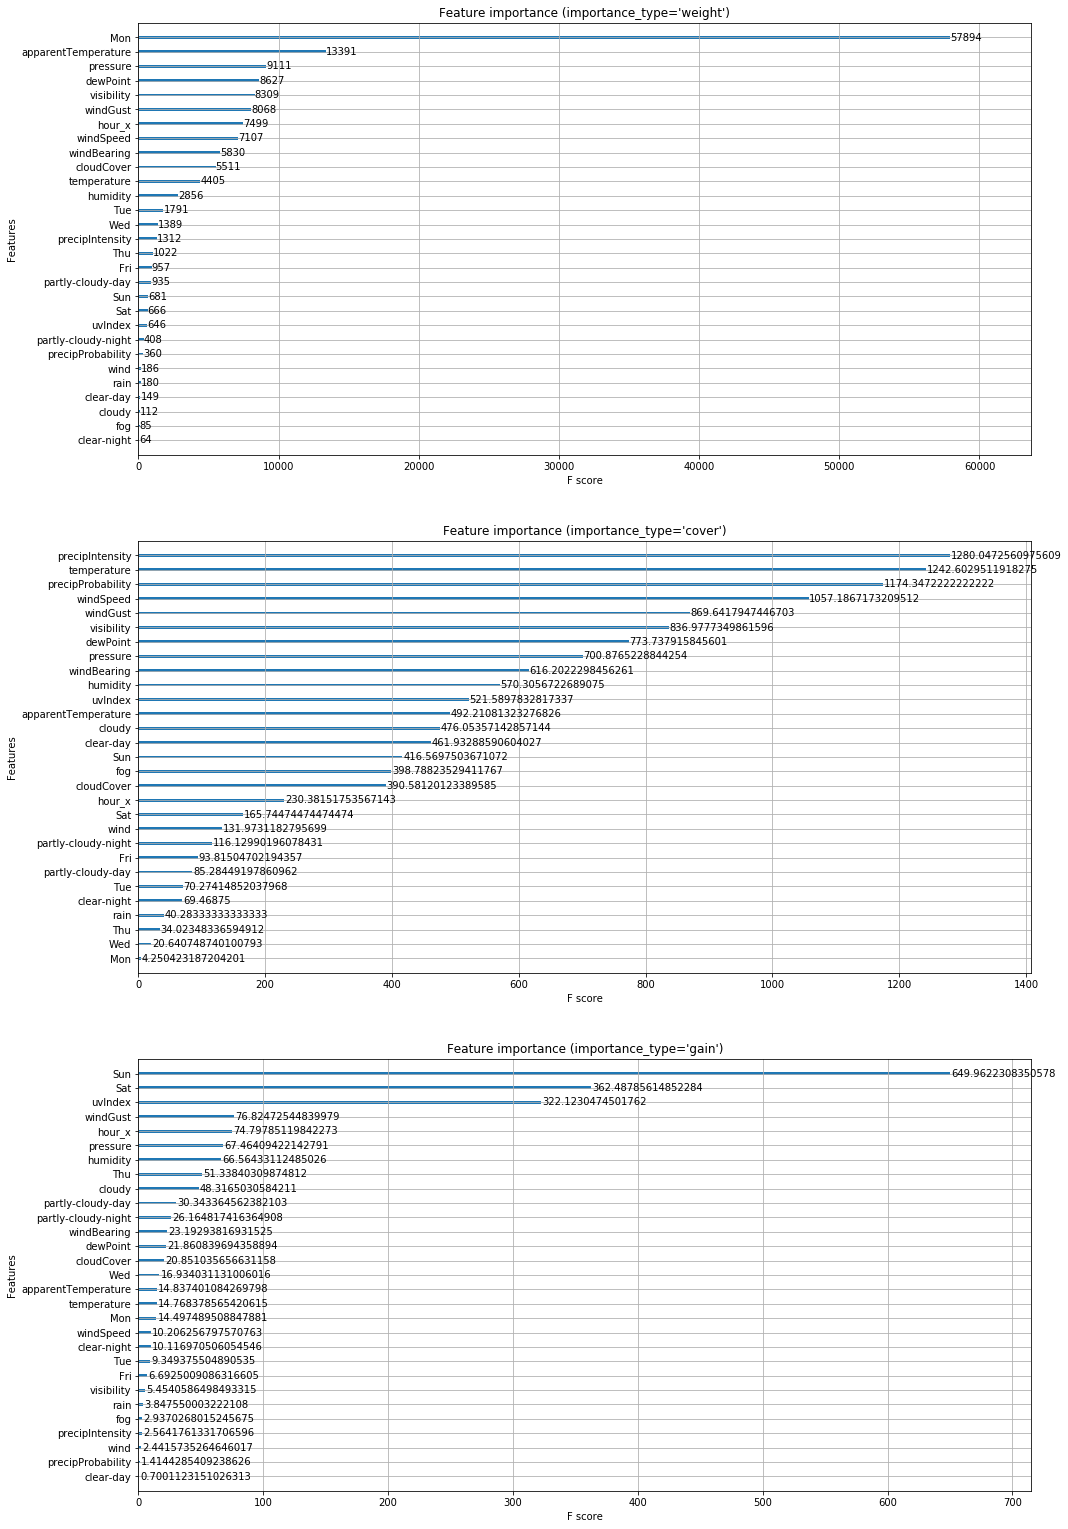

In [74]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16,27))
xgb.plot_importance(model, ax=ax1, height=0.2, importance_type='weight')
xgb.plot_importance(model, ax=ax2, height=0.2, importance_type='cover')
xgb.plot_importance(model, ax=ax3, height=0.2, importance_type='gain')

ax1.set_title('Feature importance (importance_type=\'weight\')')
ax2.set_title('Feature importance (importance_type=\'cover\')')
ax3.set_title('Feature importance (importance_type=\'gain\')')

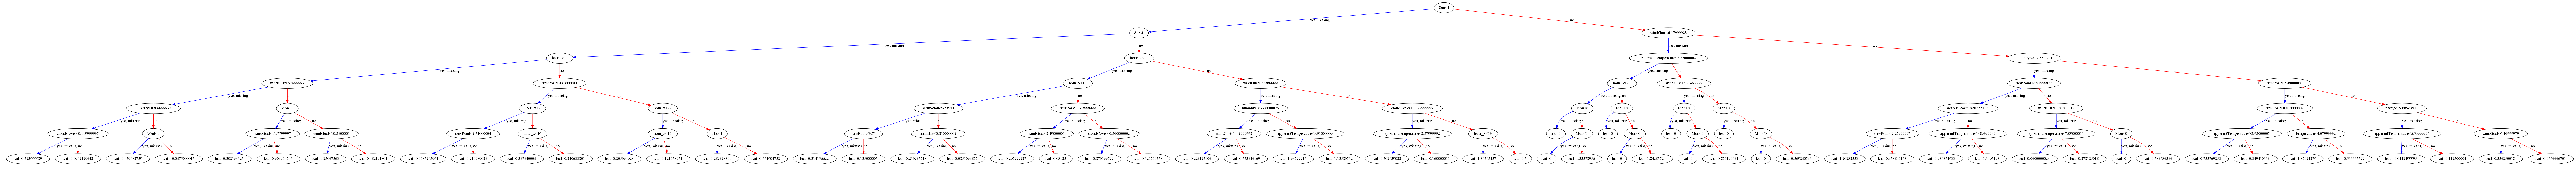

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(300,300))
xgb.plot_tree(model, ax=ax)

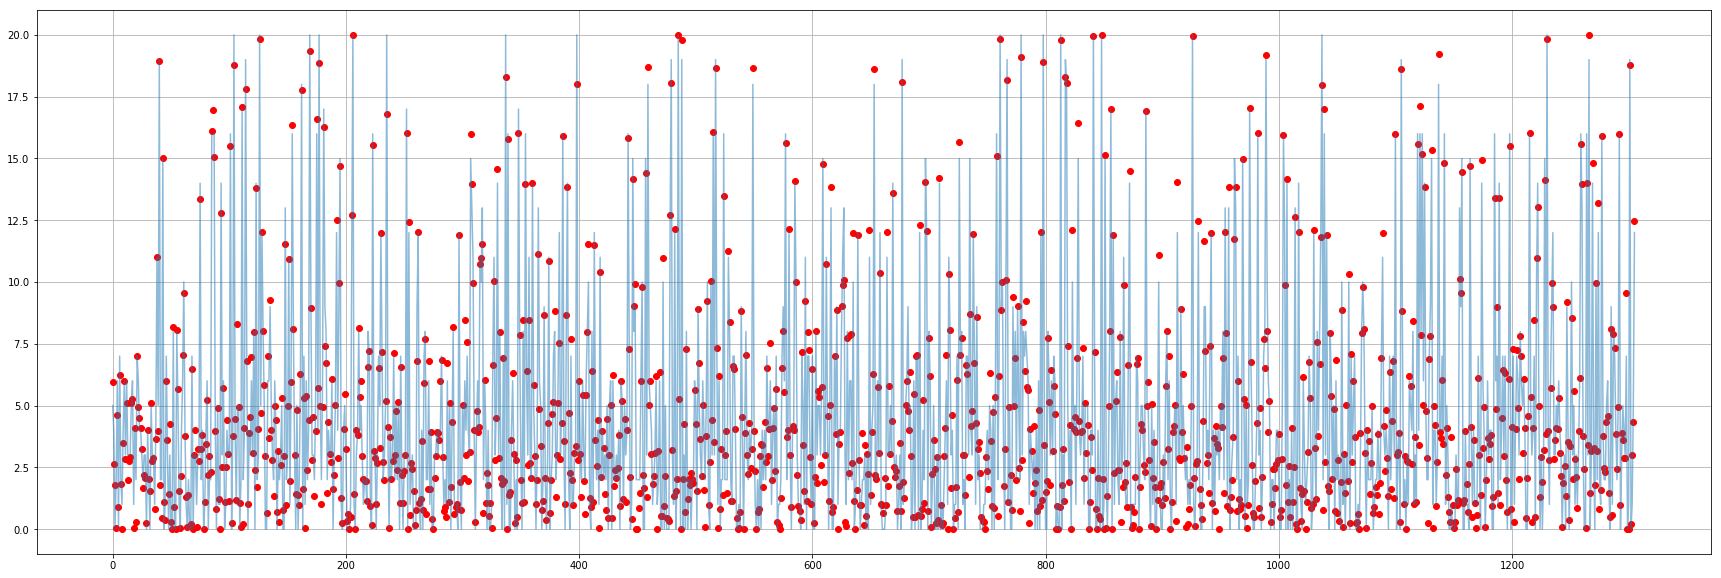

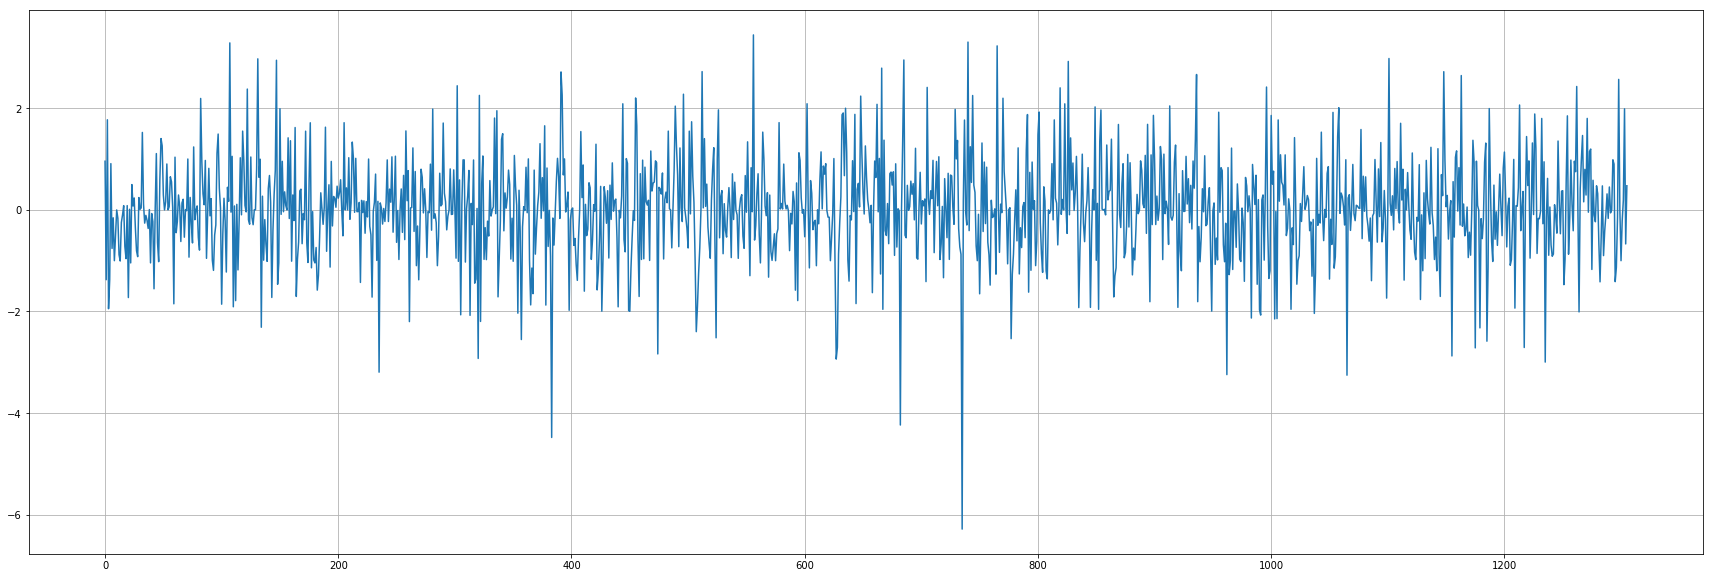

In [75]:
plt.figure(figsize=(30,10))
plt.plot(preds, 'ro')
plt.plot(labels, alpha=0.5)
plt.grid(True, which='both')
plt.figure(figsize=(30,10))
plt.plot(errors)
plt.grid(True, which='both')

In [76]:
idx = list()
for i in errors:
    if abs(i) > 5:
        idx.append(errors.index(i))

for i in idx:
    print("\nPrediction:", preds[i])
    print("Actual:", labels[i])
    print("Error:", errors[i])


Prediction: 8.714897
Actual: 15.0
Error: -6.285103


In [77]:
for i in idx:
    print(station.loc[i])
    print()

status                                      OPEN
bike_stands                                   20
available_bike_stands                         11
available_bikes                                9
last_updated                          1552226801
date_x                                  03/10/19
day_x                                        Sun
hour_x                                        14
minute_x                                       6
second_x                                      41
first_half_hour_x                           True
second_half_hour_x                         False
apparentTemperature                         1.07
cloudCover                                  0.62
dewPoint                                   -2.07
humidity                                    0.55
icon                                        wind
nearestStormBearing                            0
nearestStormDistance                           8
ozone                                     483.36
precipIntensity     

In [81]:
%%time
cvd = xgb.cv(param, dtrain, num_round, nfold=2, early_stopping_rounds=100)

Wall time: 6.86 s


In [85]:
print(cvd.tail())
cvd['test-rmse-mean'].min()

     train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
792         0.127516        0.000670        1.467107       0.028438
793         0.127474        0.000657        1.467115       0.028421
794         0.127440        0.000645        1.467105       0.028420
795         0.127386        0.000614        1.467109       0.028413
796         0.127268        0.000575        1.467059       0.028431


1.467059

Text(0, 0.5, 'RMSE')

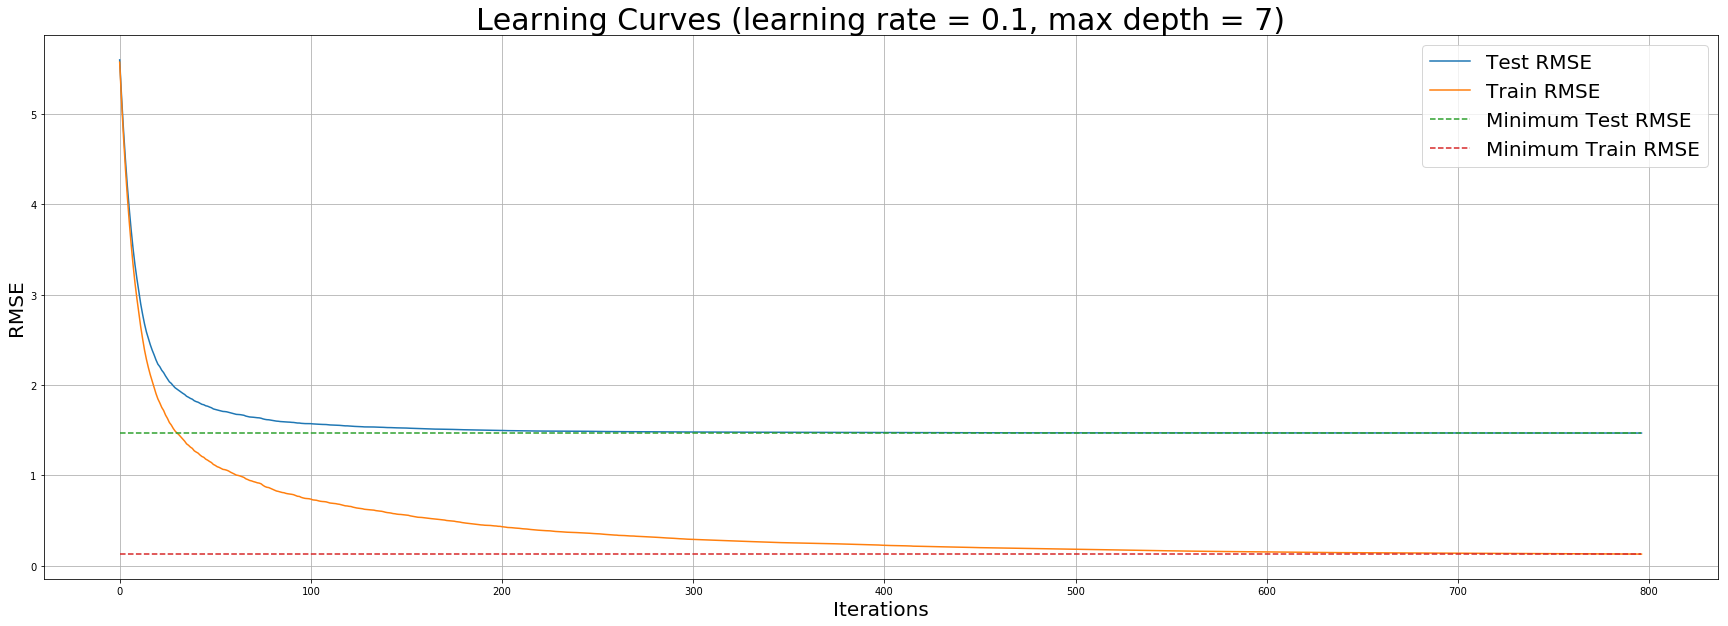

In [86]:
plt.figure(figsize=(30,10))
plt.grid(True, which='both')
plt.plot(cvd['test-rmse-mean'], label='Test RMSE')
plt.plot(cvd['train-rmse-mean'], label='Train RMSE')
plt.plot(np.linspace(cvd['test-rmse-mean'].min(),cvd['test-rmse-mean'].min(),len(cvd)), '--', label='Minimum Test RMSE')
plt.plot(np.linspace(cvd['train-rmse-mean'].min(),cvd['train-rmse-mean'].min(),len(cvd)), '--', label='Minimum Train RMSE')
plt.legend(loc='best', fontsize=20)
plt.title('Learning Curves (learning rate = 0.1, max depth = 7)', fontsize=30)
plt.xlabel('Iterations', fontsize=20)
plt.ylabel('RMSE', fontsize=20)

In [ ]:
# max_depth 7, eta 0.25 - 2.1577335
# max_depth 7, eta 0.2 - 2.1396748
# max_depth 7, eta 0.19 - 2.1113557

In [ ]:
for i in errors:
    if (abs(i)>5):
        print(errors.index(i))
print(len(errors))

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.3, random_state=10)

In [ ]:
print("There are {} samples in the training set and {} in the test set".format(X_train.shape[0], X_test.shape[0]))

In [ ]:
xgb_classif = xgb.XGBClassifier()
xgb_classif = xgb_classif.fit(X_train, y_train)

In [ ]:
print('The accuracy of the xgboost classifier is {:.2f} out of 1 on the training data'.format(bst.get_score(X_train, y_train)))
print('The accuracy of the xgboost classifier is {:.2f} out of 1 on the test data'.format(bst.get_score(X_test, y_test)))

In [ ]:
station = RDB.add_times(RDB.create_station_dictionary(2)[2])
weather = RDB.weather_times(RDB.read_weather(2))

In [ ]:
test_df = pd.merge_asof(station, weather, left_on=['last_updated'], right_on=['time'], tolerance=300, direction='nearest')

In [ ]:
test_df = test_df.dropna()
test_df = test_df.reset_index()

In [ ]:
test_df.drop('index', axis=1, inplace=True)

In [ ]:
test_df

In [ ]:
test_df